# Bird Conservation 
**Predicting threatened status with machine learning**

## Overview

There are ~10,000 known species of birds in the world today. While "only" ~150 birds are known to have gone extinct, over 1,200 species are currently globally threatened. Fortunately, we have more data on birds than ever before. After decades of research and recent crowdsourcing of observations through Cornell's eBird (https://ebird.org/home), we now have extensive data on birds' diet, habitat, range, feeding strategy, and more. As organizations continue to ramp up conservation effots, putting this data to work can help us better understand which birds are most at risk and what the key drivers are.


## Business Problem

The World Ornithological Society (WOS) has an interest in the conservation of bird species of the world. They have contracted us to build a model to accurately predict a bird's threatened status. In addition to accurate predictions, they are interested in understanding the key drivers of threatened status in order to more strategically drive their conservation efforts.

We will use machine learning techniques to construct a model trained on current threatened status and using data on bird diet, habitat, range, types of environmental threats, and other species-specific characteristics. 

Given the nature of the project, our main deliverable is less the model itself and more the intuition behind its decision-making. 

We will take a particular interest in minimizing false negatives, i.e., where our model has not predicted a bird is threatened, when in reality it is. Mis-identifying a bird as "not threatened" is the worst case scenario for the WOS. 

False positives on the other hand are not particularly impactful. The "worst" case with false positives is a slightly misguided conservation approach, which will have minimal harm. E.g., conservation efforts like protecting habitat and reducing pollution are still impactful even if they slightly miss the mark.

In our model, we will focus first on accuracy, then on tuning the model to minimize false negatives.

In [1]:
#Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Utility import
from util import model_results, high_corr

# # Processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, \
FunctionTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

#Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# # Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

# #Visual
from sklearn import tree
from xgboost import plot_tree
import catboost

## Data Understanding

The data was generated from two different sources.

* The first source is a [research paper](https://figshare.com/collections/EltonTraits_1_0_Species-level_foraging_attributes_of_the_world_s_birds_and_mammals/3306933) published in the Ecological Society of America. For most bird species, the researchers collected diet information, foraging (feeding) strategy, and other characteristics about the species (weight, nocturnal, passerine). 
* The second was [BirdLife.org](https://www.birdlife.org), a non profit focused on bird conservation. Their [data zone](http://datazone.birdlife.org/species/search) includes information on bird habitat, region, and the nature of the threat these species face (e.g., agriculture, climate change, etc).
* The two sources were concatenated on Scientific or English name

Target variable:

* The target is threatened status from BirdLife.org (they in turn pull this information from IUCN, which maintains threatened status information across all animals, not just birds).
* They consider species that are vulnerable, endangered, and critically endangered as being "globally threatened". This forms the bin for our target variable

Data Features: 
* We will ignore several extraneous "object" columns such as "source" and "entered by" (useful information, but can't help a predictive model)
* We will engineer some additional categories

Data Cleaning:
* Fortunately, the main columns we intend to use don't require extensive cleaning (there are no nulls for example), but there will be some outliers to remove and normalization steps to take if we use a linear model

In [3]:
# Update Pandas settings for printing dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
# Read in data
df_birds = pd.read_csv('data/birds_withrange.csv', low_memory=False)

In [5]:
# Drop duplicate name and scientific name columns
df_birds.drop(columns=['English name_x', 'English name_y', 'Scientific Name'], axis=1, inplace=True)

df_birds.head()

,SpecID,PassNonPass,IOCOrder,BLFamilyLatin,BLFamilyEnglish,BLFamSequID,Taxo,Scientific,English,Diet-Inv,Diet-Vend,Diet-Vect,Diet-Vfish,Diet-Vunk,Diet-Scav,Diet-Fruit,Diet-Nect,Diet-Seed,Diet-PlantO,Diet-5Cat,Diet-Source,Diet-Certainty,Diet-EnteredBy,ForStrat-watbelowsurf,ForStrat-wataroundsurf,ForStrat-ground,ForStrat-understory,ForStrat-midhigh,ForStrat-canopy,ForStrat-aerial,PelagicSpecialist,ForStrat-Source,ForStrat-SpecLevel,ForStrat-EnteredBy,Nocturnal,BodyMass-Value,BodyMass-Source,BodyMass-SpecLevel,BodyMass-Comment,Record-Comment,Family,Global IUCN Red List Category,endemic_breeding,migratory,africa,antarctica,asia,australasia,caribbean,central_amer,central_asia,europe,high_seas,mid_east,north_amer,oceania,south_amer,agriculture_threat,biological_threat,climate_change_threat,energy_mining_threat,geological_threat,human_intrusions_threat,natural_systems_threat,pollution_threat,res_comm_dev_threat,transportation_threat,invasive_threat,artificial_aquatic,artificial_terrestrial,caves_subterranean,desert,forest,grassland,introduced_vegetation,marine_coastal_supratidal,marine_intertidal,marine_neritic,marine_oceanic,rocky_areas,savanna,shrubland,wetlands_inland,breeding_range
0,37.00,Nonpasseriformes,Rheiformes,Rheidae,Rheas,3.00,BL3,Rhea americana,Greater Rhea,20.00,10.00,10.00,0.00,0.00,0.00,20.00,0.00,20.00,20.00,Omnivore,Ref_1,A,Jennifer,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,Ref_1,1.00,Jessica,0.00,23000.00,Dunning08,1.00,NaN,NaN,Rheidae (Rheas),NT,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,SA
1,38.00,Nonpasseriformes,Rheiformes,Rheidae,Rheas,3.00,BL3,Rhea pennata,Lesser Rhea,20.00,0.00,0.00,0.00,10.00,0.00,0.00,0.00,30.00,40.00,PlantSeed,Ref_1,A,Jennifer,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,Ref_1,1.00,Jessica,0.00,23900.00,Dunning08,1.00,NaN,NaN,Rheidae (Rheas),LC,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,SA
2,45.00,Nonpasseriformes,Casuariiformes,Casuariidae,Cassowaries,4.00,BL3,Casuarius casuarius,Southern Cassowary,10.00,0.00,0.00,0.00,10.00,0.00,80.00,0.00,0.00,0.00,FruiNect,Ref_1,A,Jennifer,0.00,0.00,80.00,20.00,0.00,0.00,0.00,0.00,Ref_1,1.00,Jessica,0.00,44000.00,Dunning08,1.00,NaN,NaN,"Casuariidae (Cassowaries, Emus)",LC,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,AU
3,46.00,Nonpasseriformes,Casuariiformes,Casuariidae,Cassowaries,4.00,BL3,Casuarius bennetti,Dwarf Cassowary,10.00,0.00,0.00,0.00,10.00,0.00,80.00,0.00,0.00,0.00,FruiNect,Ref_1,B,Jennifer,0.00,0.00,80.00,20.00,0.00,0.00,0.00,0.00,Ref_1,1.00,Jessica,0.00,34999.99,Dunning08,1.00,NaN,NaN,"Casuariidae (Cassowaries, Emus)",LC,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,AU
4,47.00,Nonpasseriformes,Casuariiformes,Casuariidae,Cassowaries,4.00,BL3,Casuarius unappendiculatus,Northern Cassowary,20.00,0.00,0.00,0.00,10.00,0.00,60.00,0.00,0.00,10.00,FruiNect,Ref_1,A,Jennifer,0.00,0.00,80.00,20.00,0.00,0.00,0.00,0.00,Ref_1,1.00,Jessica,0.00,46073.85,Dunning08,1.00,NaN,NaN,"Casuariidae (Cassowaries, Emus)",LC,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,AU


In [6]:
df_birds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9597 entries, 0 to 9596
Data columns (total 84 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SpecID                         9597 non-null   float64
 1   PassNonPass                    9597 non-null   object 
 2   IOCOrder                       9597 non-null   object 
 3   BLFamilyLatin                  9597 non-null   object 
 4   BLFamilyEnglish                9597 non-null   object 
 5   BLFamSequID                    9597 non-null   float64
 6   Taxo                           9597 non-null   object 
 7   Scientific                     9597 non-null   object 
 8   English                        9597 non-null   object 
 9   Diet-Inv                       9597 non-null   float64
 10  Diet-Vend                      9597 non-null   float64
 11  Diet-Vect                      9597 non-null   float64
 12  Diet-Vfish                     9597 non-null   f

In [7]:
#Object summary
columns = df_birds.columns

df_birds[[c for c in columns if df_birds[c].dtype == 'object']].describe()

,PassNonPass,IOCOrder,BLFamilyLatin,BLFamilyEnglish,Taxo,Scientific,English,Diet-5Cat,Diet-Source,Diet-Certainty,Diet-EnteredBy,ForStrat-Source,ForStrat-EnteredBy,BodyMass-Source,BodyMass-Comment,Record-Comment,Family,Global IUCN Red List Category,breeding_range
count,9597,9597,9597,9597,9597,9597,9597,9597,9597,9597,9325,9597,9597,9597,330,225,9597,9597,6894
unique,2,40,194,194,2,9597,9592,5,31,5,5,109,9,10,19,1,242,9,57
top,Passeriformes,Passeriformes,Tyrannidae,Tyrant-flycatchers,BL3,Psitteuteles goldiei,Hepatic Tanager,Invertebrate,Ref_4,A,Jennifer,Ref_11,Jessica,Dunning08,MarceloR,DataFromSplit,Tyrannidae (Tyrant-flycatchers),LC,SA
freq,5705,5705,420,420,9511,1,2,4843,822,7639,4433,1058,6265,8321,307,225,415,7448,1907


In [8]:
#Numerical summary
df_birds[[c for c in columns if df_birds[c].dtype == 'float64']].describe()

,SpecID,BLFamSequID,Diet-Inv,Diet-Vend,Diet-Vect,Diet-Vfish,Diet-Vunk,Diet-Scav,Diet-Fruit,Diet-Nect,Diet-Seed,Diet-PlantO,ForStrat-watbelowsurf,ForStrat-wataroundsurf,ForStrat-ground,ForStrat-understory,ForStrat-midhigh,ForStrat-canopy,ForStrat-aerial,PelagicSpecialist,ForStrat-SpecLevel,Nocturnal,BodyMass-Value,BodyMass-SpecLevel,endemic_breeding,migratory,africa,antarctica,asia,australasia,caribbean,central_amer,central_asia,europe,high_seas,mid_east,north_amer,oceania,south_amer,agriculture_threat,biological_threat,climate_change_threat,energy_mining_threat,geological_threat,human_intrusions_threat,natural_systems_threat,pollution_threat,res_comm_dev_threat,transportation_threat,invasive_threat,artificial_aquatic,artificial_terrestrial,caves_subterranean,desert,forest,grassland,introduced_vegetation,marine_coastal_supratidal,marine_intertidal,marine_neritic,marine_oceanic,rocky_areas,savanna,shrubland,wetlands_inland
count,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00
mean,7344.09,113.09,55.71,2.57,2.15,2.72,0.36,0.60,15.03,5.85,10.69,4.33,2.54,4.48,31.72,23.60,23.53,12.08,2.03,0.03,0.97,0.03,273.31,0.92,0.26,0.18,0.23,0.01,0.31,0.13,0.08,0.12,0.06,0.05,0.00,0.06,0.13,0.03,0.33,0.20,0.21,0.11,0.05,0.00,0.03,0.08,0.05,0.06,0.04,0.09,0.03,0.35,0.00,0.02,0.57,0.16,0.00,0.04,0.04,0.04,0.02,0.04,0.15,0.30,0.16
std,4654.52,54.64,37.12,12.07,7.67,12.43,3.80,5.44,25.63,19.21,21.77,13.23,14.13,17.00,37.81,25.83,26.19,21.62,10.78,0.17,0.18,0.18,1643.51,0.28,0.44,0.39,0.42,0.10,0.46,0.34,0.27,0.32,0.23,0.23,0.06,0.24,0.33,0.18,0.47,0.40,0.41,0.32,0.21,0.07,0.18,0.27,0.21,0.24,0.19,0.29,0.17,0.48,0.06,0.13,0.50,0.37,0.02,0.19,0.19,0.20,0.13,0.19,0.35,0.46,0.37
min,28.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.90,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3434.00,68.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,15.16,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,6961.00,109.00,60.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.00,20.00,20.00,0.00,0.00,0.00,1.00,0.00,36.23,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,10829.00,163.00,100.00,0.00,0.00,0.00,0.00,0.00,20.00,0.00,10.00,0.00,0.00,0.00,60.00,40.00,40.00,20.00,0.00,0.00,1.00,0.00,127.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
max,20107.00,194.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,1.00,1.00,1.00,111000.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


#### Threatened Status EDA
From the Global IUCN Red List, "globally threatened" are species that are vulnerable, endangered, and critically endangered. When binned, these will form our target "threatened" variable. 

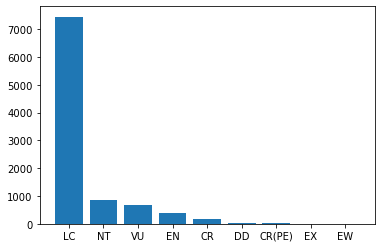

In [9]:
#review threatened distribution
red_list = df_birds['Global IUCN Red List Category'].value_counts()
plt.bar(x=red_list.index, height=red_list);

#### Body Weight EDA
**Body weight** is one of the few non-categorical variables in our dataset.

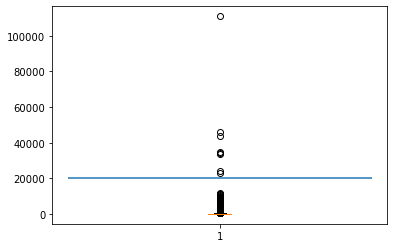

In [10]:
# Plot body weight
# Notes: appears to be a few outliers here above 20,000 grams
plt.boxplot(df_birds['BodyMass-Value']);
plt.hlines(20000, xmin=0, xmax=2);

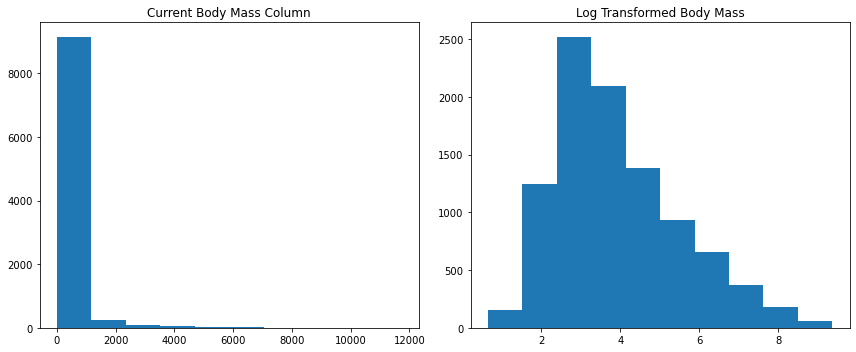

In [11]:
# Log transforming BodyMass significantly improves normalcy

fig, ax = plt.subplots(ncols=2, figsize=(12,5))

ax[0].hist(df_birds[df_birds['BodyMass-Value'] < 20000]['BodyMass-Value'])
ax[0].set_title('Current Body Mass Column')

ax[1].hist(np.log(df_birds[df_birds['BodyMass-Value'] < 20000]['BodyMass-Value']))
ax[1].set_title('Log Transformed Body Mass')

plt.tight_layout();

In [12]:
weight_outliers = df_birds[df_birds['BodyMass-Value'] > 20000][['English', 'BodyMass-Value', 'Global IUCN Red List Category']]
weight_outliers

,English,BodyMass-Value,Global IUCN Red List Category
0,Greater Rhea,23000.00,NT
1,Lesser Rhea,23900.00,LC
2,Southern Cassowary,44000.00,LC
3,Dwarf Cassowary,34999.99,LC
4,Northern Cassowary,46073.85,LC
3240,Emperor Penguin,33569.33,NT
8509,Ostrich,111000.00,LC
8510,Emu,34093.25,LC


Googled each of these species and the weights are reasonably accurate. The biggest 'outlier' in body weight is an ostrich. Excluding these bird species from final analysis on the basis that these are large, flightless birds. Furthermore, since body mass is one of the few continuous variables within the dataset outliers will have an impact on modeling. 

#### Diet columns EDA

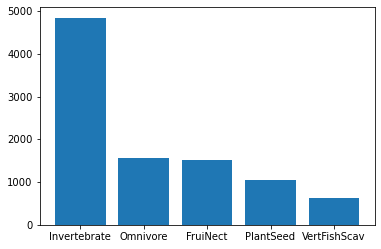

In [13]:
#review distribution of diet
diet = df_birds['Diet-5Cat'].value_counts()
plt.bar(x=diet.index, height=diet);

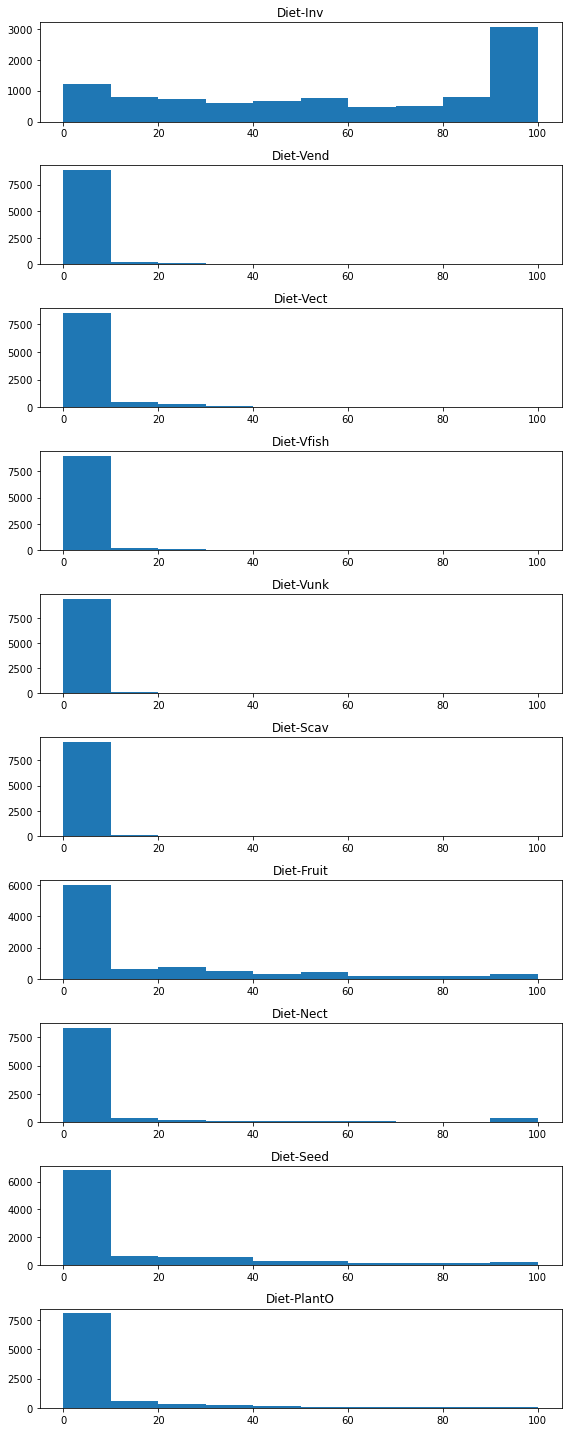

In [14]:
# Check distribution of diet cols
# Comments: None of them appear to have a normal distribution. Will need some transformation if doing 
# a linear model. Log is not suitable because there are 0s so may need to use log1p
diet_cols = ['Diet-Inv', 'Diet-Vend', 'Diet-Vect', 'Diet-Vfish', 'Diet-Vunk', 'Diet-Scav', 'Diet-Fruit',
             'Diet-Nect', 'Diet-Seed', 'Diet-PlantO']

fig, ax = plt.subplots(nrows=len(diet_cols), figsize=(8,20))

for i, col in enumerate(diet_cols):
    ax[i].hist(df_birds[col])
    ax[i].set_title(col);

plt.tight_layout();

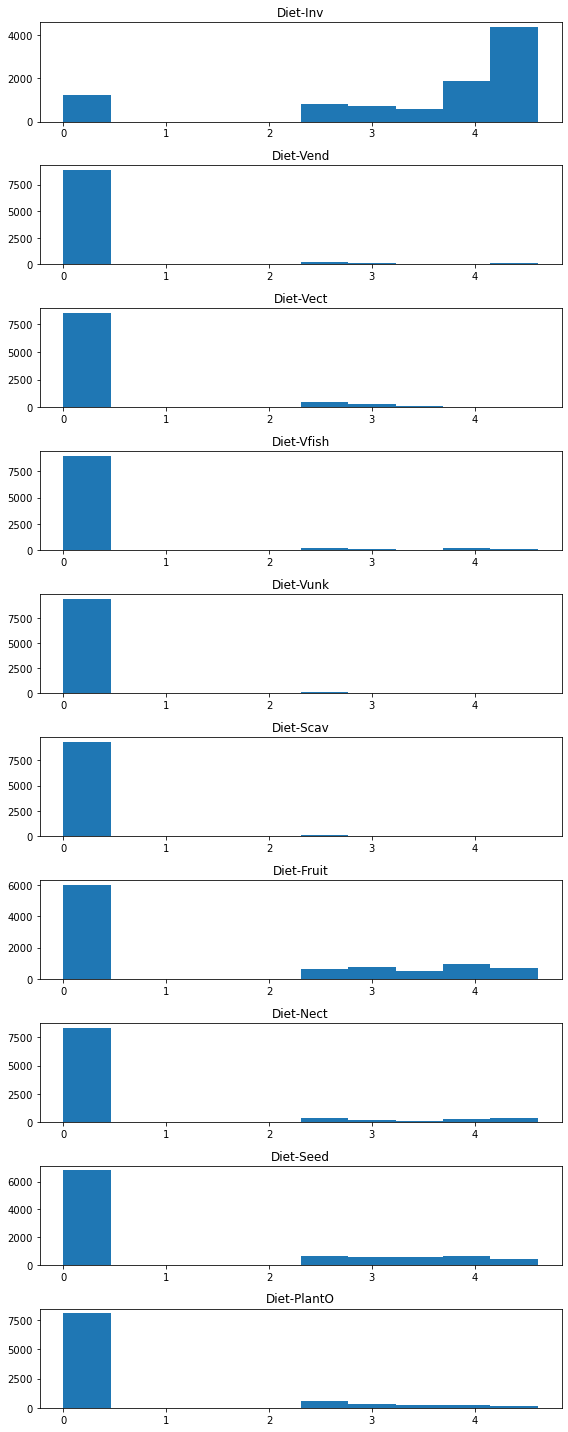

In [15]:
# Test log transforming. Note we need to add one because substantial number of 0s in the dataset
# Doesn't actually do all that much. May need to use a model that doesn't handle non-normality as well

fig, ax = plt.subplots(nrows=len(diet_cols), figsize=(8,20))

for i, col in enumerate(diet_cols):
    ax[i].hist(np.log1p(df_birds[col]))
    ax[i].set_title(col);

plt.tight_layout();

#### Foraging Columns EDA

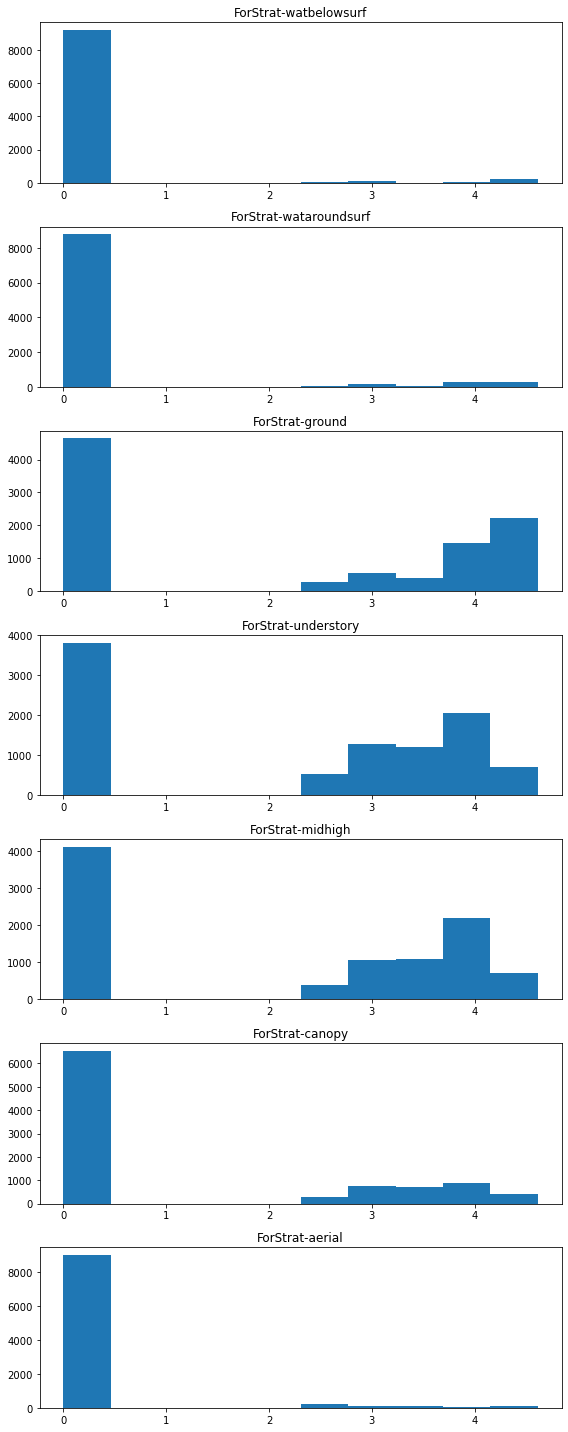

In [16]:
# Check distribution of foraging columns after log transforming
foraging_cols = ['ForStrat-watbelowsurf', 'ForStrat-wataroundsurf', 'ForStrat-ground', 'ForStrat-understory',
                'ForStrat-midhigh', 'ForStrat-canopy', 'ForStrat-aerial']

fig, ax = plt.subplots(nrows=len(foraging_cols), figsize=(8,20))

for i, col in enumerate(foraging_cols):
    ax[i].hist(np.log1p(df_birds[col]))
    ax[i].set_title(col);

plt.tight_layout();

## Data Preparation

After exploring the data we will: 
1. Remove outliers and any birds currently classified as extinct. 
2. Create the target variable.
3. One Hot Encode Passerine and Diet-5Cat categorical columns.

### Remove Outliers and Extinct Birds
Since body mass is one of the few continuous variables in the dataset outliers will have a strong impact on modeling. Birds that are outliers in weight are all large flightless. These species are not represntative of the population of birds. To ensure accurate predictions, we will remove these outliers. Therefore, this model is not sutable for predicting the threatened status of birds >20,000 grams.  

Some birds are classified as extinct in the world, and in the wild. Since these birds would not respond to conservation efforts given by the WOS we are eliminating them from the data set. Furthermore, the model is designed to predict threatened status. Extinct does not fit into this target. 

In [17]:
# Remove outliers: all birds with a weight over 20K grams
weight_threshold = 20000
df_clean = df_birds.copy()

df_clean = df_clean[df_clean['BodyMass-Value'] < weight_threshold]

In [18]:
#Eliminating already extinct birds
df_clean = df_clean[(df_clean['Global IUCN Red List Category'] != 'EX') &
                    (df_clean['Global IUCN Red List Category'] != 'EW') &
                    (df_clean['Global IUCN Red List Category'] != 'DD')]

In [19]:
# Create the target variable

df_clean['threatened'] = 0

df_clean.loc[(df_clean['Global IUCN Red List Category'] == 'VU') |
             (df_clean['Global IUCN Red List Category'] == 'EN') |
             (df_clean['Global IUCN Red List Category'] == 'CR') |
             (df_clean['Global IUCN Red List Category'] == 'CR(PE)'), 'threatened'] = 1

**Encode categorical columns** 

In [20]:
# One hot encode Passerine and Diet 5 Category
to_encode = df_clean[['PassNonPass', 'Diet-5Cat']]

#intantiate encoder
ohe = OneHotEncoder(drop='first', categories='auto', sparse=False)

cat_transformed = ohe.fit_transform(to_encode)

df_ohe = pd.DataFrame(cat_transformed, columns=ohe.get_feature_names(), index=df_clean.index)

#### Data Engineering
The below is based partly off intuition and seeing which columns have been most impactful in some of our models.

* Add columns for 'number of threats', 'number of habitats', and 'number of regions'. Idea is that quantity of threats faced could have predictive value. Also species that don't rely on a single habitat could be more resilient.
* Add a column for 'marine' habitat. Then create an interaction between that and (1) pollution threat and (2) climate change threat. The idea is that these species might be more sensitive to these types of threats.
* We found that agriculture and invasive species were one of the better decision tree predictors. We created new columns for the interaction of agricultural threat and num_habitats = 1 (and same for invasive species). The idea is to focus in on species that rely only on a single habitat, which also faces the most impactful threat.

In [21]:
# Identify relevant columns

threats = ['agriculture_threat', 'biological_threat', 'climate_change_threat', 'energy_mining_threat',
          'geological_threat', 'human_intrusions_threat', 'natural_systems_threat', 'pollution_threat', 
          'res_comm_dev_threat', 'transportation_threat', 'invasive_threat']

habitats = ['artificial_aquatic', 'artificial_terrestrial', 'caves_subterranean', 'desert', 'forest', 'grassland',
           'introduced_vegetation', 'marine_coastal_supratidal', 'marine_intertidal', 'marine_neritic', 
            'marine_oceanic', 'rocky_areas', 'savanna', 'shrubland', 'wetlands_inland']

regions = ['africa', 'antarctica', 'asia', 'australasia', 'caribbean', 'central_amer', 'central_asia',
          'europe', 'high_seas', 'mid_east', 'north_amer', 'oceania', 'south_amer']

In [22]:
# Add number of threats, habitats, and regions

df_clean['num_threats'] = df_clean[threats].sum(axis=1)
df_clean['num_habitats'] = df_clean[habitats].sum(axis=1)
df_clean['num_regions'] = df_clean[regions].sum(axis=1)

In [23]:
# Create interaction of marine habitat and pollution / climate change

df_clean['marine_hab'] = 0
df_clean.loc[(df_clean['marine_coastal_supratidal'] == 1) |
             (df_clean['marine_intertidal'] == 1) |
             (df_clean['marine_neritic'] == 1) |
             (df_clean['marine_oceanic'] == 1), 'marine_hab'] = 1

df_clean['marine_x_pollution'] = df_clean['marine_hab'] * df_clean['pollution_threat']
df_clean['marine_x_climatechg'] = df_clean['marine_hab'] * df_clean['climate_change_threat']

In [24]:
# Add instance where species faces both an agriculture / invasive threat and only has one habitat.

df_clean['ag+habitat'] = 0 
df_clean.loc[(df_clean['agriculture_threat']==1) & (df_clean['num_habitats']==1), 'ag+habitat'] = 1

df_clean['inv+habitat'] = 0 
df_clean.loc[(df_clean['invasive_threat']==1) & (df_clean['num_habitats']==1), 'inv+habitat'] = 1

df_clean['all+habitat'] = 0 
df_clean.loc[(df_clean['num_threats']>=3) & (df_clean['num_habitats']==1), 'inv+habitat'] = 1

**Variable removal (for linear models only)**
* Decided to remove Diet-Vunk and ForStrat-watbelowsurf
* Removed Diet-Vunk because it's reasonably positively correlated with Vend and has "middle of the road" representation in the data
* Decided to remove ForStrat-watbelowsurf because that's the least correlated with Diet-Vunk
* Removed marine habitat, pollution threat, and climate change because of new interaction variables we created above

In [25]:
# Create X and Y variables

to_remove = ['SpecID', 'PassNonPass', 'IOCOrder', 'BLFamilyLatin', 'BLFamilyEnglish', 'BLFamSequID', 'Taxo',
            'Scientific', 'English', 'Diet-5Cat', 'Diet-Source', 'Diet-Certainty', 'Diet-EnteredBy', 
            'BodyMass-Source', 'BodyMass-SpecLevel', 'BodyMass-Comment', 'Record-Comment', 'Family',
            'Global IUCN Red List Category', 'breeding_range', 'threatened', 'ForStrat-Source', 
             'ForStrat-EnteredBy', 'Diet-Vect', 'ForStrat-watbelowsurf', 'marine_hab', 'pollution_threat',
            'climate_change_threat', 'ForStrat-SpecLevel']

X = df_clean.drop(columns=to_remove, axis=1)
X = pd.concat([X, df_ohe], axis=1)

y = df_clean['threatened']

### train-test-split

In [26]:
# Perform test train split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    stratify=y)

### Multicollinearity
* Check for high multicollinearity in the train set. Doing this after the split to avoid data leakage
* Conclusions:
    * Remove OHE x1_Invertebrate column
    * Remove Europe as that seems to be most common denominator among region flags
    * Remove OHE x1_PlantSeed column
    * Combine biological / agriculture threat into one interaction column. bio_or_ag_threat
    * Combine marine_neritic and marine_oceanic

In [27]:
hc = high_corr(X_train, 0.6)

hc

,cc
pairs,
"(Diet-Inv, Diet-Inv)",1.00
"(x1_Invertebrate, Diet-Inv)",0.90
"(num_threats, biological_threat)",0.79
"(num_threats, agriculture_threat)",0.77
"(central_asia, europe)",0.73
"(mid_east, europe)",0.72
"(x1_PlantSeed, Diet-Seed)",0.71
"(biological_threat, agriculture_threat)",0.69
"(ag+habitat, inv+habitat)",0.69


In [28]:
# Fix collinearity issues described above
X_train = X_train.copy()
# First on X_train
X_train['bio_or_ag_threat'] = 0
X_train.loc[(X_train['biological_threat'] == 1) |
            (X_train['agriculture_threat'] == 1), 'bio_or_ag_threat'] = 1

X_train['marine_ner_oceanic'] = 0
X_train.loc[(X_train['marine_neritic'] == 1) |
            (X_train['marine_oceanic'] == 1), 'marine_ner_oceanic'] = 1

X_train = X_train.drop(columns=['x1_Invertebrate', 'x1_PlantSeed', 'europe', 'marine_neritic', 
                                'marine_oceanic', 'biological_threat', 'agriculture_threat'], axis=1)


# Then on X_test
X_test['bio_or_ag_threat'] = 0
X_test.loc[(X_test['biological_threat'] == 1) |
           (X_test['agriculture_threat'] == 1), 'bio_or_ag_threat'] = 1

X_test['marine_ner_oceanic'] = 0
X_test.loc[(X_test['marine_neritic'] == 1) |
           (X_test['marine_oceanic'] == 1), 'marine_ner_oceanic'] = 1

X_test = X_test.drop(columns=['x1_Invertebrate', 'x1_PlantSeed', 'europe', 'marine_neritic', 
                              'marine_oceanic', 'biological_threat', 'agriculture_threat'], axis=1)

<ipython-input-28-eba9b2f80dd4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['bio_or_ag_threat'] = 0
C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-28-eba9b2f80dd4>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

### Pipeline Set Up:
* We have no nulls to take care of
* Log transform size
* Log1p transform the diet and foraging columns
* Use min max scaler to standardize the remaining columns

In [29]:
# Identify relevant columns for each transformation

log_t_cols = ['BodyMass-Value']
temp = diet_cols + foraging_cols
removed = ['Diet-Vect', 'ForStrat-watbelowsurf', 'marine_hab', 'pollution_threat', 'climate_change_threat']
log_1p_cols = [col for col in temp if col not in removed]

min_max_cols = [x for x in X_train.columns if x not in log_t_cols + log_1p_cols]

In [30]:
# Create Pipelines for preprocessing

log_transformer = Pipeline(steps=[
        ('log_transformer', FunctionTransformer(np.log))])

log_1ptransformer = Pipeline(steps=[
        ('log_1ptransformer', FunctionTransformer(np.log1p))
])

min_max = Pipeline(steps=[
        ('min_max_scalar', MinMaxScaler())])

In [31]:
# Create preprocessor using column transformer

preprocessor = ColumnTransformer(transformers=[
                                ('log', log_transformer, log_t_cols),
                                ('log1p', log_1ptransformer, log_1p_cols), 
                                ('min_max', min_max, min_max_cols)])

# Modeling 
Modeling will take an iterative approach. Since we want our model to be interpretable, we will  focus on logistic regression and various decision tree approaches as the potential final model. The aim is to produce an accurate model with high Recall score. In context, this means we are not 'missing' threatend species by incorrectly predicting them as not threatened when they are actually threatened. 

## 1. Dummy Model

This model will act as a baseline model to compare future modeling against. According to this model, if one was to guess 'Not Threatened', they would be accurate 87% of the time. Our aim will be to do better than that with the focus of reducing false negatives. 

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train results
Accuracy: 0.8701
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC: nan

Test results
Accuracy: 0.8700
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC: nan


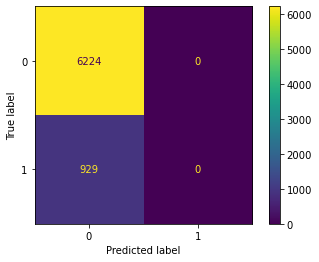

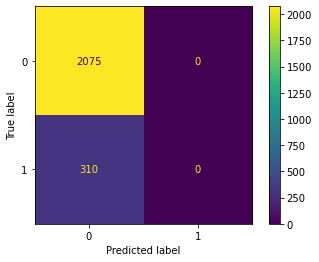

In [32]:
dc = DummyClassifier(random_state=42, strategy='most_frequent')

dc.fit(X_train, y_train)

model_results(dc, X_train, y_train, X_test, y_test, plot_cf=True)

## 2. Simple Logistic Regression
* First simple logistic regression without any hyperparameter tuning or scaling
* Requires 4,000 steps to converge. Performs reasonably similarly across Train and Test
* Has only improve accuracy by 2-3 ppt from Dummy Model
* More false negatives than false positives (hence lower recall)

In [33]:
# instantiate model
simple_log = LogisticRegression(max_iter=10000, random_state=42)

simple_log.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [34]:
# Cross validation
simple_output = cross_validate(simple_log, X_train, y_train, cv=5, scoring=['accuracy', 'roc_auc'])

print(f"Accuracy: {simple_output['test_accuracy']}")
print(f"AUC {simple_output['test_roc_auc']}")

Accuracy: [0.91544375 0.90286513 0.91474493 0.91258741 0.90559441]
AUC [0.94883189 0.95424278 0.95522304 0.95166395 0.9535145 ]


Train results
Accuracy: 0.9149
Precision: 0.6932
Recall: 0.6179
F1 Score: 0.6534
ROC: 0.9584

Test results
Accuracy: 0.9015
Precision: 0.6354
Recall: 0.5677
F1 Score: 0.5997
ROC: 0.9467


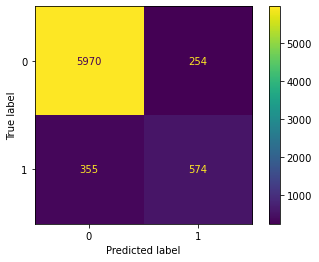

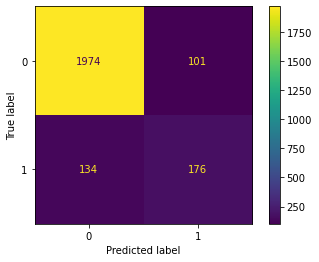

In [35]:
model_results(simple_log, X_train, y_train, X_test, y_test, plot_cf=True)

## 3. Logistic Regression with pre-processing
* Apply min max scalar
* Log transform weight column
* Try class_weights = balanced in the log reg

Results:
* The accuracy has gotten slightly worse, but interestingly, this approach has materially reduced false negatives

In [36]:
log_reg = Pipeline(steps=[
                  ('preprocessor', preprocessor),
                  ('log_clf', LogisticRegression(random_state=42, class_weight='balanced', max_iter=5000))])

log_reg.fit(X_train, y_train)

output2 = cross_validate(log_reg, X_train, y_train, cv=3, scoring=['accuracy', 'roc_auc'])

output2['test_accuracy']

array([0.88427673, 0.88380872, 0.8783557 ])

Train results
Accuracy: 0.8792
Precision: 0.5195
Recall: 0.9452
F1 Score: 0.6705
ROC: 0.9482

Test results
Accuracy: 0.8837
Precision: 0.5288
Recall: 0.9591
F1 Score: 0.6817
ROC: 0.9566


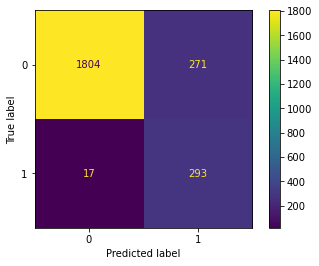

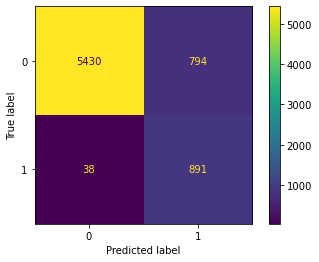

In [37]:
model_results(log_reg, X_test, y_test, X_train, y_train, plot_cf=True)

Following this model, we used a GridSearch to find the best hypterparameters for tuning the logistical regression model. We aimed to tune the `class_weight` parameter by iterating through different weights. Focusing on `class_weight`was important given the imbalanced nature of our target variable. We also aimed to find the best penalty parameters. 

The following parameters were passed through the GridSearchCV:

` log_param_grid = {
'log_clf__penalty': ['l1', 'l2'],
'log_clf__C': [0.01, 0.1, 1, 100, 1000],
'log_clf__class_weight': [{0: x, 1: 1.0-x} for x in weights],
'log_clf__max_iter': [10000],
'log_clf__random_state': [42]
}`


The best parameters produced by the GridSearchCV are listed below. They were used as the parameters in the model below. 
`{'log_clf__C': 1000,
 'log_clf__class_weight': {0: 0.44999999999999996, 1: 0.55},
 'log_clf__max_iter': 10000,
 'log_clf__penalty': 'l2',
 'log_clf__random_state': 42}` 

[0.90859539 0.91484899 0.90771812]

Train results
Accuracy: 0.9157
Precision: 0.6741
Recall: 0.6792
F1 Score: 0.6767
ROC: 0.9586

Test results
Accuracy: 0.9002
Precision: 0.6139
Recall: 0.6258
F1 Score: 0.6198
ROC: 0.9463


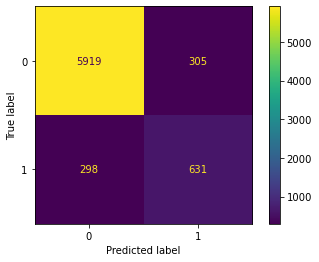

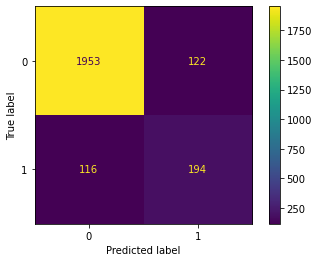

In [38]:
log_reg_best_params = Pipeline(steps=[
                              ('preprocessor', preprocessor),
                              ('log_clf', LogisticRegression(random_state=42, class_weight={0: 0.45, 1: 0.55}, max_iter=10000, C=1000))
])

log_reg_best_params.fit(X_train, y_train)

output3 = cross_validate(log_reg_best_params, X_train, y_train, cv=3, scoring=['accuracy', 'roc_auc'])

print(output3['test_accuracy']) 
print('')

model_results(log_reg_best_params, X_train, y_train, X_test, y_test, plot_cf=True)


The logistic regression models created predictions that were better than baseline, but still did not meet the objective of reucing the number of false negatives. 

# 4. Recursive Feature Selection
The next approach was to apply recursive feature selection to test if we can simplify the model without sacraficing accuracy. We fit `RFE` to a logistic regression model and evaluated the top 10 features using `.ranking_` attribute. 

New X_train, X_test Dataframes were created to contain the top features. An additional logistical regression model was fit and evaluated based on these features. The resulting model was 90.83% accurate and had a recall score of 57% on the test set. 

In conclusion, REF did not meet our goal of high accuracy and recall. To see the code and model evaluation review [this notebook](https://github.com/CGPinDC/Bird-Classification-Project/blob/425ab482a6caa4bb7df106f628f3716350ef7f03/notebooks/jeff/Marvel_notebook.ipynb). 

## Adjusting Thresholds
The next step we applied was to use `predict_proba` to a logistical regression model and adjust the prediction threshold of the model to minimize the false negative rate. Iterating through the different levels of thresholds produced a trade off between accuracy and recall. As model recall improved, the accuracy decreased. 

In conclusion, this method improved recall, thereby reducing the number of false negatives, but also decreased our accuracy.  To see the code and metrics review [this notebook](https://github.com/CGPinDC/Bird-Classification-Project/blob/425ab482a6caa4bb7df106f628f3716350ef7f03/notebooks/jeff/Marvel_notebook.ipynb). 

# 5. SMOTE
Applying SMOTE to modeling is an attempt to adjust the class imbalance of our data. SMOTE generates synthetic threatened samples. 

In [39]:
# Resample the train data using SMOTE

X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

[0.88473896 0.93253012 0.9313253  0.93611892 0.93009241]

Train results
Accuracy: 0.9002
Precision: 0.5747
Recall: 0.8902
F1 Score: 0.6985
ROC: 0.9563

Test results
Accuracy: 0.8939
Precision: 0.5597
Recall: 0.8613
F1 Score: 0.6785
ROC: 0.9359


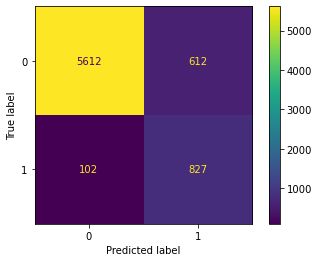

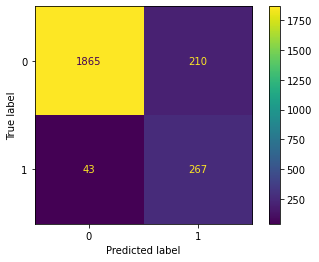

In [40]:
log_reg_resamp = Pipeline(steps=[
                           ('preprocessor', preprocessor),
                           ('log_clf', LogisticRegression(random_state=42, max_iter=5000, C=1000))
])

log_reg_resamp.fit(X_train_resampled, y_train_resampled)

output_resamp = cross_validate(log_reg_resamp, X_train_resampled, y_train_resampled, cv=5, scoring=['accuracy', 'roc_auc'])

print(output_resamp['test_accuracy']) 
print('')

model_results(log_reg_resamp, X_train, y_train, X_test, y_test, plot_cf=True)

SMOTE reduced the instances of false negatives over previous models, but the accuracy of the model suffers. 

# 6. Decision Tree
Our next approach was to use a decision tree since our data contains mostly categorical variables and our aim is to produce a model with interpretable results. 

In the previous models, we dropped columns to account multi-collinearity. This is no longer relevant for modeling with decision trees. As such, re-reading in the the clean data. 

In [41]:
#re-read in clean data
df = pd.read_csv('data/df.csv')

#Train/Test/Split
X = df.drop(columns='threatened')
y = df['threatened']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42, 
                                                    stratify=y)

Used an iterative process to create, evaluate, and tune decision trees. For additional modling review [this notebook](https://github.com/CGPinDC/Bird-Classification-Project/blob/425ab482a6caa4bb7df106f628f3716350ef7f03/notebooks/crystal/Decision_Tree_Models.ipynb). 

1. Ran a simple un-tuned decision tree to establish baseline tree performance. 
2. Iterated through `max_depth` parameters and evaluated AUC for each iteration
3. Iterated through `min_samples_split` parametersa nd evaluated AUC for each iteration
4. Iterated through `min_samples_leaf` parameters and evaluated AUC for each iteration

The resulting model is based on the tuned parameters.

CV test_score: [0.87074357 0.87065369 0.86230876 0.87343533 0.87065369]
Train results
Accuracy: 0.8719
Precision: 0.5023
Recall: 0.9376
F1 Score: 0.6541
ROC: nan

Test results
Accuracy: 0.8653
Precision: 0.4893
Recall: 0.9548
F1 Score: 0.6470
ROC: nan


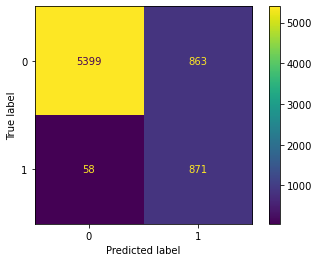

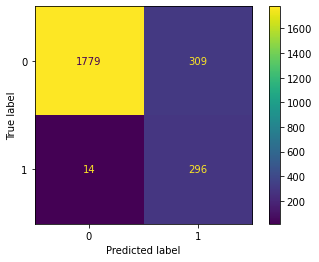

In [42]:
dt_model = DecisionTreeClassifier(criterion='entropy', 
                               max_depth= 6, 
                               min_samples_split= 0.25, 
                               min_samples_leaf = 0.15,
                               random_state=42)

dt_model.fit(X_train, y_train)

dt_model_cv = cross_validate(dt_model, X_train, y_train)
print('CV test_score:', dt_model_cv['test_score'])

model_results(dt_model, X_train, y_train, X_test, y_test, plot_cf=True)

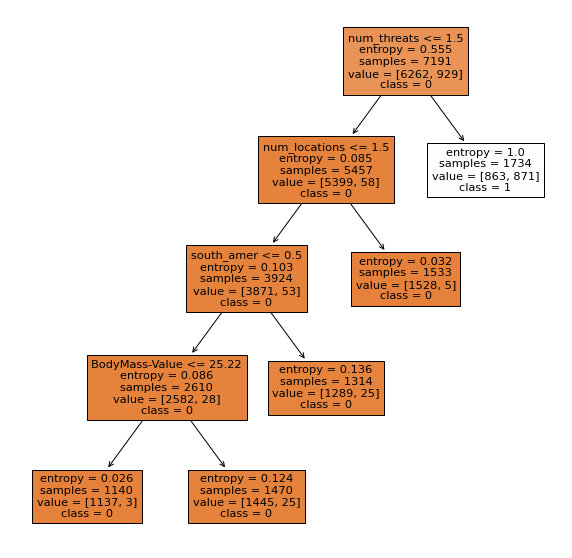

In [43]:
#plot tree
fig, axes = plt.subplots(figsize = (10, 10))

tree.plot_tree(dt_model, 
               feature_names = X.columns, 
               class_names= np.unique(y).astype('str'), 
               filled = True)

plt.show();

After this initial tuned model, we conducted a GridSearch scoring for 'recall'. 

Parameters for the GridSearch were: 

`param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter' : ['best', 'random'], 
    'min_samples_split': [0.0025, 0.005, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32],
    'max_depth': [d for d in range(4, 12)], 
    'class_weight': [{1: 0.13, 0: 0.87},
                     {1: 1, 0: 4},
                     {1: 2, 0: 3},
                     {1: 0.3, 0: 0.7},
                     {1: 0.4, 0: 0.5},
                     {1: 0.45, 0: 0.55},
                     {1: 1, 0: 1}, 'balanced']
} `

The resulting best parameters were: 
`{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 0.04, 'splitter': 'random'}`

CV test_score: [0.85753996 0.86648122 0.8379694  0.85396384 0.87760779]
Train results
Accuracy: 0.8662
Precision: 0.4911
Recall: 0.9839
F1 Score: 0.6552
ROC: nan

Test results
Accuracy: 0.8620
Precision: 0.4835
Recall: 0.9935
F1 Score: 0.6505
ROC: nan


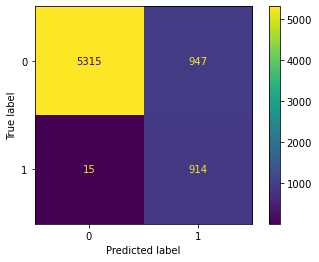

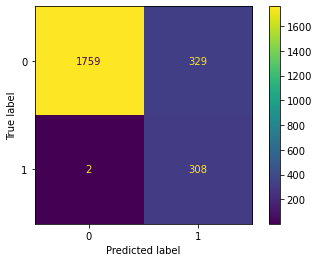

In [44]:
gs_tree = DecisionTreeClassifier(random_state=42, 
                                   class_weight='balanced', 
                                   criterion = 'gini', 
                                   max_depth=4, 
                                   min_samples_split=0.04, 
                                   splitter='random')

gs_tree.fit(X_train, y_train)

gs_tree_cv = cross_validate(gs_tree, X_train, y_train, cv=5)
print(f'CV test_score:', gs_tree_cv['test_score'])

model_results(gs_tree, X_train, y_train, X_test, y_test, plot_cf=True)

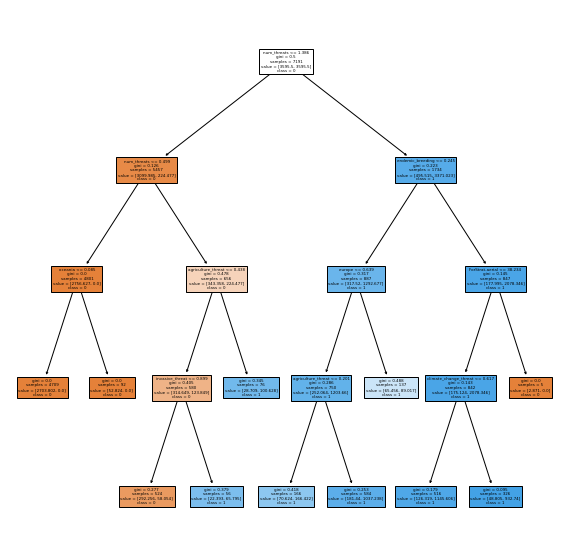

In [45]:
#plot grid_search tuned tree
fig, axes = plt.subplots(figsize = (10, 10))

tree.plot_tree(gs_tree, 
               feature_names = X.columns, 
               class_names= np.unique(y).astype('str'), 
               filled = True)

plt.show();

In [46]:
#important features
gs_tree_features = dict(zip(X_train.columns, gs_tree.feature_importances_))
pd.DataFrame.from_dict(gs_tree_features, orient='index').sort_values(by=0, ascending=False).head()

,0
num_threats,0.94
agriculture_threat,0.02
invasive_threat,0.02
endemic_breeding,0.01
europe,0.01


This model reduces the number of false negatives. However, the model's accuracy is worse than the first Dummy model.

A trend worth noticing is **both** decision tree models considered the most important feature to be the number of threats a species faces. 

# 7. XGBoost
XGBoost is a decision-tree Machine Learning algorithim that uses gradient boosting. 

We conducted a GridSearch, scoring for 'recall', for the following parameters: 

`param_grid = {
    'learning_rate':[0.05, 0.1, 0.2], 
    'max_depth': [4, 6, 8],
    'n_estimators': [50, 100],
    'tree_method': ['auto', 'hist'],
    'process_type': ['default', 'update'], 
    'subsample': [0.5, 0.25], 
    'use_label_encoder':[False]}`

The search produced the following:

`best_params: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 50, 'process_type': 'default', 'subsample': 0.5, 'tree_method': 'auto', 'use_label_encoder': False}`

[11:41:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:41:56] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:41:57] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:41:58] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

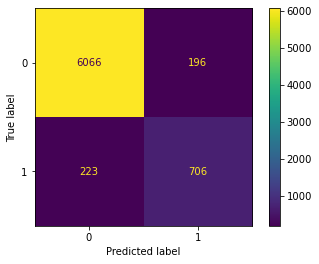

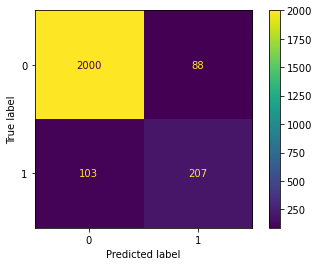

In [47]:
xgb = XGBClassifier(random_state=42, 
                    learning_rate= 0.05, 
                    max_depth = 6, 
                    n_estimators = 50, 
                    process_type= 'default', 
                    subsample=0.5, 
                    use_label_encoder = False)

xgb.fit(X_train, y_train)

xgb_cv = cross_validate(xgb, X_train, y_train, cv=3)
print(f'CV test_score:', xgb_cv['test_score'])

model_results(xgb, X_train, y_train, X_test, y_test, plot_cf=True)

In [48]:
#top 5 important features
xgb_features = dict(zip(X_train.columns, xgb.feature_importances_))
pd.DataFrame.from_dict(xgb_features, orient='index').sort_values(by=0, ascending=False).head()

,0
num_threats,0.26
endemic_breeding,0.03
central_asia,0.03
europe,0.03
agriculture_threat,0.02


The amove model is the best model produced with XGBoost other models are found [here](https://github.com/CGPinDC/Bird-Classification-Project/blob/main/notebooks/crystal/Decision_Tree_Models.ipynb)

So far, XGBoost produced the most accurate models performing with 91% accuracy on the test data. This model, like others before it, produced a high number of false negatives. 

In all models, **number of threats** continues to be identified as the most important feature. Additionally, **agricultural threat** and **endemic breeding** re-appear as important features along with regions. 

# 8. CatBoost
Catboost is a gradient boosting algorithm on decision trees. 
* It builds decison trees differetnly, and faster, than XGBoost used above. 
* CatBoost allows us to pass in paramaters related to categorical columns. This is helpful because our data is primarily categorical in natures. 
* It allows us to able maintain a higherlevel of accuracy while tuning the class_weights parameters

In [49]:
#define the categorial columns for CatBoostClassifier parameter
not_cat=['Diet-Inv', 'Diet-Fish', 'Diet-Scav', 'Diet-Fruit', 'Diet-Nect',
       'Diet-Seed', 'Diet-PlantO', 'ForStrat-watbelowsurf',
       'ForStrat-wataroundsurf', 'ForStrat-ground', 'ForStrat-understory',
       'ForStrat-midhigh', 'ForStrat-canopy', 'ForStrat-aerial','BodyMass-Value', 
       'num_habitats', 'num_threats', 'num_locations', 'Diet-Vertebrates']
    
cat_features = [x for x in X_train.columns if x not in not_cat]

#cat_features must be int type. Convert cat_features columnst to int
for col in cat_features: 
    X_train[col] = X_train[col].astype(int)
    X_test[col] = X_test[col].astype(int)

<ipython-input-49-bca937e41440>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype(int)
<ipython-input-49-bca937e41440>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype(int)


### CatBoost Model 1: 
We conducted a GridSearch of the following parameters: 

`param_grid = {
    'loss_function': ['Logloss', 'Recall'], 
    'iterations': [10,25,50],
    'learning_rate':[0.01, 0.1],
    'max_depth': [5, 8],
    'min_data_in_leaf':[5, 10, 60]}`
    
The resulting best paramters were: ` {'iterations': 50, 'learning_rate': 0.1, 'loss_function': 'Logloss', 'max_depth': 8, 'min_data_in_leaf': 5}` 

Running a model with tuned with these parameters, along with `cat_features` produces the most accurate model so far. 92% accuracy and 69% recall on test data. 

### CatBoost Model 2: Final Model
The class imbalance in our data set has a strong impact on our modeling. By tuning class weights to oversample the threatened species we are able to produce a model that is high in accuracy and recall.  

Train results
Accuracy: 0.9330
Precision: 0.6609
Recall: 0.9882
F1 Score: 0.7921
ROC: nan

Test results
Accuracy: 0.9016
Precision: 0.5743
Recall: 0.9226
F1 Score: 0.7079
ROC: nan


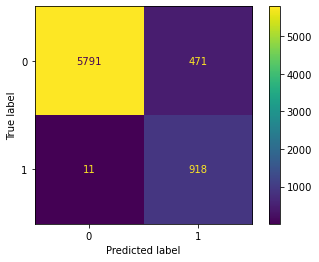

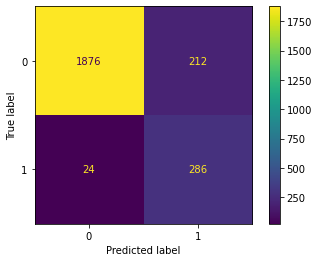

In [50]:
cb_model = CatBoostClassifier(random_seed=42,
                            iterations=100,
                            learning_rate=0.1,
                            custom_loss='Recall',
                            max_depth=7,
                            class_weights=(1,3.5),  #oversampling technique
                            cat_features=cat_features)


cb_model.fit(X_train, y_train, verbose=False)

model_results(cb_model, X_train, y_train, X_test, y_test, plot_cf=True)

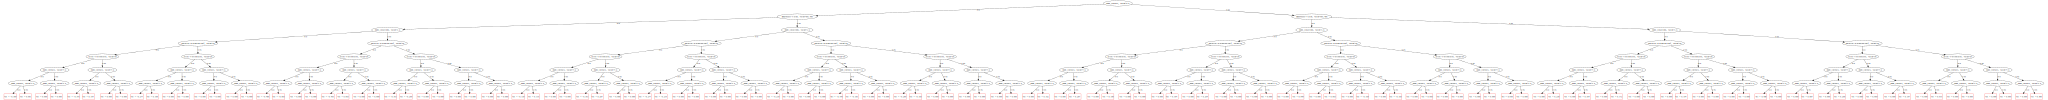

In [51]:
#plot catboost tree
pool = Pool(X_test, y_test, 
            cat_features=cat_features, 
            feature_names=list(X_test.columns))

cb_model.plot_tree(pool=pool, 
                   tree_idx=0)

In [52]:
#important features
cb_model_features = dict(zip(X_train.columns, cb_model.feature_importances_))

pd.set_option('display.max_rows', None)
pd.DataFrame.from_dict(cb_model_features, orient='index').sort_values(by=0, ascending=False)

,0
num_threats,38.20
agriculture_threat,7.03
endemic_breeding,6.51
num_locations,4.41
BodyMass-Value,3.96
invasive_threat,2.95
Diet-Inv,2.55
ForStrat-midhigh,2.14
climate_change_threat,2.00
biological_threat,1.61


## Final Model Evaluation 
The final model was made using CatBoostClassifier. Tuning parameters to address the class imbalance in the data produced the best results with 90% accuracy and recall of 92%. 

This model is the best for the WOS because it is the right balance of accuracy with minimizing the number of false negatives. In this context, false negatives represent a missed opportunity for protecting a threatened species. As with the previous run decision-tree models, this model identified the same important top features to predict threatened status. The number of threats a species faced, agricultural threats, and endemic breeding were the top three features of the final model. 

### Recommendations
Using this model to predict the threatened status of bird species, we recommend the WOS: 
* Preserve habitat at risk of agriculture or resource use expansion and focus on eradicating invasive species
* Focus conservation efforts on Oceania and High Seas, which have the highest incidence of threatened species. Europe, Central America, and Asia were strong predictors of Not Threatened status, suggesting resources can be shifted away from these regions.
* Endemic breeders (species that are only located in a single country when breeding) are particularly at risk for being threatened and could benefit from additional conservation efforts.

## Conclusion 
This model performs better than a baseline model with accuracy and does not miss many threatened species. However, it still produced a number of false positives. Using feature importance, the WOS can strategically plan conservation efforts. 